In [1]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, AncillaRegister
from qiskit.circuit import Gate
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Any
from IPython.display import display, clear_output

In [28]:
def encode(variable: NDArray[np.float64]) -> Statevector:
    concatenated = np.concatenate((variable, variable))
    concatenated = concatenated / np.linalg.norm(concatenated)
    
    state = Statevector(concatenated)
    ancilla = Statevector([1.0, 0.0])

    return state.expand(ancilla)

In [4]:
def c_gate(lambdas: NDArray[np.float64]) -> Gate:
    qc = QuantumCircuit(2)
    
    qc.cp(lambdas[0], 1, 0, ctrl_state='0')
    qc.cx(1, 0, ctrl_state='0')
    qc.cp(lambdas[0], 1, 0, ctrl_state='0')
    qc.cx(1, 0, ctrl_state='0')

    qc.cp(lambdas[1], 1, 0, ctrl_state='1')
    qc.cx(1, 0, ctrl_state='1')
    qc.cp(lambdas[1], 1, 0, ctrl_state='1')
    qc.cx(1, 0, ctrl_state='1')
    
    return qc.to_gate(label='C')

In [29]:
def collision(num_qubits: int, lambdas: NDArray[np.float64]) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1

    qc.h(ancilla)
    qc.append(c_gate(lambdas).control(1, ctrl_state='0'), [ancilla, 0, num_qubits - 2])
    qc.append(c_gate(-1 * lambdas).control(1, ctrl_state='1'), [ancilla, 0, num_qubits - 2])
    qc.h(ancilla)

    return qc

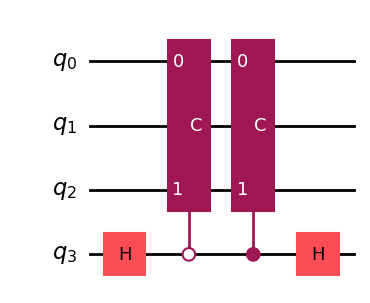

In [30]:
# Generate random lambdas
random_lambdas = np.random.rand(2)

# Create the c_gate for 5 qubits
circuit = collision(4, random_lambdas)

# Draw the circuit
circuit.draw('mpl')

In [8]:
def r_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits - 1, -1, -1):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='R')

def l_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='L')


In [9]:
def propagation(num_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    
    target_qubits = list(range(num_qubits - 1))
    r_ctrl = r_gate(num_qubits - 1).control(1, ctrl_state='0')
    qc.append(r_ctrl, [num_qubits - 1] + target_qubits)
    l_ctrl = l_gate(num_qubits - 1).control(1, ctrl_state='1')
    qc.append(l_ctrl, [num_qubits - 1] + target_qubits)
    
    return qc

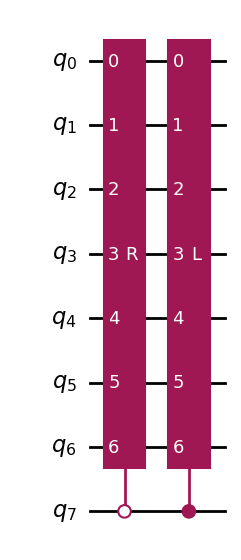

In [10]:
circuit = propagation(8)
# Draw the circuit
circuit.draw('mpl')

In [22]:
def macros() -> QuantumCircuit:
    qc = QuantumCircuit(2)
    
    qc.swap(0, 1)
    qc.h(1)
    
    return qc

In [12]:
def init_plot(variable: NDArray[np.float64]):
    fig, ax = plt.subplots()
    line, = ax.plot(range(len(variable)), variable, 'b-')
    ax.set_xlim(0, len(variable) - 1)
    ax.set_ylim(0, 0.3)
    ax.grid(True)
    ax.set_xlabel('Site')
    ax.set_ylabel('Density')
    ax.set_title('Density Distribution Over Time')
    
    return fig, ax, line

In [13]:
def update_plot(fig: Any, line: Any, variable: NDArray[np.float64]) -> None:
    line.set_data(range(len(variable)), variable)
    fig.canvas.draw()
    fig.canvas.flush_events()
    clear_output(wait=True)  # Clear previous output to avoid clutter
    display(fig)  # Display the updated figure
    plt.pause(0.1)  # Small pause to allow plot to update
    return line

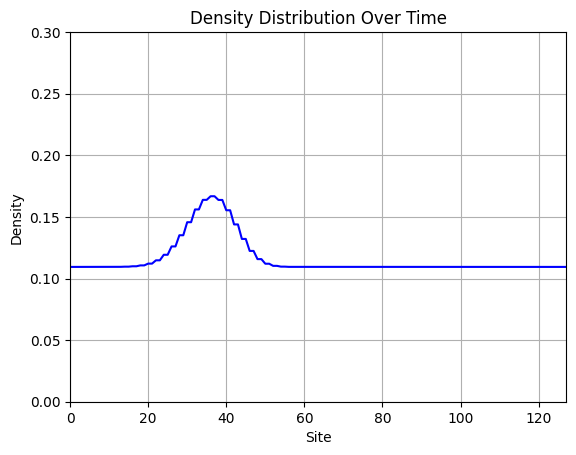

In [ ]:

num_sites = 128

dimensions = 1
velocities = [1, -1]
weights = np.array([0.5, 0.5])
speed_of_sound = 1
advection = 0.5
iterations = 50

lambdas = np.array([np.arccos(w * (1 + (v * advection)/speed_of_sound**2)) for w, v in zip(weights, velocities)])

density = np.full(num_sites, 0.1)
density[11] = 0.5
density[12] = 0.5

original_norm = np.linalg.norm(density)

state = encode(density)

if state.num_qubits is None:
    raise ValueError("Statevector must have a number of qubits defined.")

qc = QuantumCircuit(state.num_qubits)
qc.append(collision(state.num_qubits, lambdas), list(range(state.num_qubits)))
qc.append(propagation(state.num_qubits - 1), list(range(0, state.num_qubits - 1)))
qc.append(macros(), [state.num_qubits - 2, state.num_qubits - 1])


fig, ax, line = init_plot(density)

for i in range(iterations):
    update_plot(fig, line, density)
    state = state.evolve(qc)

    vals = np.array(state)[:num_sites]
    density = np.real(2 * original_norm * vals)
    state = encode(vals)